In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
len(X)

1712

In [4]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=123)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [6]:
from keras import models, layers
from keras import Input
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
model.trainable = True
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
#customizing my layers
additional_model = models.Sequential()
additional_model.add(model)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 100356    
Total params: 14,815,044
Trainable params: 14,815,044
Non-trainable params: 0
_________________________________________________________________


In [8]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [9]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='VGG16_1_no callback.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [10]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [11]:
# class_weight = {0: 1.1,
#                 1: 1.1,
#                 2: 1,
#                 3: 1}

In [12]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=60, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint])

Epoch 1/60
43/42 [==============================] - 17s 406ms/step - loss: 1.3849 - acc: 0.2900 - auc: 0.5188 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.1002 - val_loss: 1.3800 - val_acc: 0.2770 - val_auc: 0.5237 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.1013
Epoch 2/60
43/42 [==============================] - 11s 252ms/step - loss: 1.3761 - acc: 0.3083 - auc: 0.5315 - precision: 0.0421 - recall: 1.8413e-04 - f1score: 0.1016 - val_loss: 1.3348 - val_acc: 0.3644 - val_auc: 0.5466 - val_precision: 0.3529 - val_recall: 0.0018 - val_f1score: 0.1047
Epoch 3/60
43/42 [==============================] - 12s 271ms/step - loss: 1.3130 - acc: 0.3484 - auc: 0.5685 - precision: 0.3882 - recall: 0.0050 - f1score: 0.1089 - val_loss: 1.2568 - val_acc: 0.3936 - val_auc: 0.5892 - val_precision: 0.4446 - val_recall: 0.0100 - val_f1score: 0.1123
Epoch 4/60
43/42 [==============================] - 12s 274ms/step - loss: 1.2517 - acc: 0.3718 - auc: 0.6081 - precisi

43/42 [==============================] - 12s 278ms/step - loss: 0.7684 - acc: 0.6669 - auc: 0.8033 - precision: 0.6135 - recall: 0.3234 - f1score: 0.1672 - val_loss: 1.0265 - val_acc: 0.5306 - val_auc: 0.8040 - val_precision: 0.6145 - val_recall: 0.3255 - val_f1score: 0.1487
Epoch 58/60
43/42 [==============================] - 12s 280ms/step - loss: 0.7595 - acc: 0.6640 - auc: 0.8048 - precision: 0.6154 - recall: 0.3274 - f1score: 0.1688 - val_loss: 1.1045 - val_acc: 0.5015 - val_auc: 0.8055 - val_precision: 0.6164 - val_recall: 0.3294 - val_f1score: 0.1454
Epoch 59/60
43/42 [==============================] - 12s 277ms/step - loss: 0.7937 - acc: 0.6413 - auc: 0.8061 - precision: 0.6169 - recall: 0.3311 - f1score: 0.1654 - val_loss: 1.0691 - val_acc: 0.5306 - val_auc: 0.8068 - val_precision: 0.6177 - val_recall: 0.3329 - val_f1score: 0.1449
Epoch 60/60
43/42 [==============================] - 12s 277ms/step - loss: 0.7805 - acc: 0.6691 - auc: 0.8074 - precision: 0.6184 - recall: 0.3346 

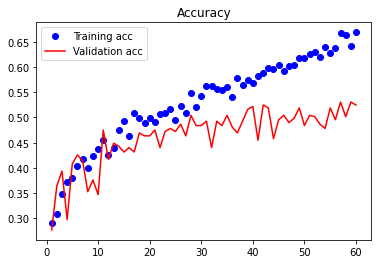

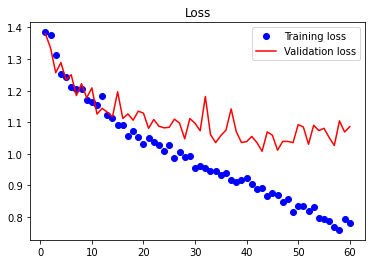

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [14]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

343/343 [==============================] - 1s 3ms/step
loss: 1.086, accuracy: 0.525, auc: 0.808, precision: 0.619, recall: 0.337, f1score: 0.147


In [45]:
from keras.models import Model, load_model

new_model = models.load_model('./G_팔로미_models/Inception v3_fine tuning_2_no callback(539).hdf5',compile=False)


new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [46]:
X_test=np.load('X_val.npy')
y_test=np.load('y_val.npy')

In [47]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

571/571 [==============================] - 4s 6ms/step
loss: 0.996, accuracy: 0.539, auc: 0.811, precision: 0.596, recall: 0.399, f1score: 0.145
